## Generating names

homework done for coursera intro to dl course

In [2]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
import os
start_token = " "

with open("names") as f:
    names = f.read()[:-1].split('\n')
    names = [start_token+name for name in names]

In [4]:
print ('n samples = ',len(names))
for x in names[::1000]:
    print (x)
    


n samples =  7944
 Abagael
 Claresta
 Glory
 Liliane
 Prissie
 Geeta
 Giovanne
 Piggy


max length = 16


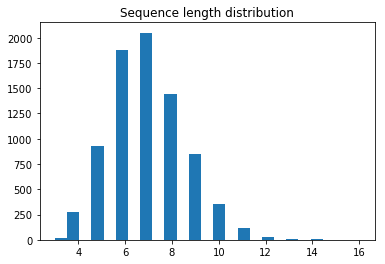

In [5]:
MAX_LENGTH = max(map(len,names))
print("max length =", MAX_LENGTH)

plt.title('Sequence length distribution')
plt.hist(list(map(len,names)),bins=25);

In [6]:
#all unique characters go here
#tokens = <all unique characters in the dataset>
tokens = set(''.join(names))

tokens = list(tokens)

n_tokens = len(tokens)
print ('n_tokens = ',n_tokens)

assert 50 < n_tokens < 60


n_tokens =  55


In [7]:
#token_to_id = ###YOUR CODE HERE: create a dictionary of {symbol -> its  index in tokens }
token_to_id = dict(zip(tokens, np.arange(len(tokens))))


In [8]:
assert len(tokens) == len(token_to_id), "dictionaries must have same size"

for i in range(n_tokens):
    assert token_to_id[tokens[i]] == i, "token identifier must be it's position in tokens list"

print("Seems alright!")

Seems alright!


In [9]:
def to_matrix(names,max_len=None,pad=0,dtype='int32'):
    """Casts a list of names into rnn-digestable matrix"""
    
    max_len = max_len or max(map(len,names))
    names_ix = np.zeros([len(names),max_len],dtype) + pad

    for i in range(len(names)):
        name_ix = list(map(token_to_id.get,names[i]))
        names_ix[i,:len(name_ix)] = name_ix

    return names_ix.T

In [10]:
#Example: cast 4 random names to matrices, pad with zeros
print('\n'.join(names[::2000]))
print(to_matrix(names[::2000]).T)

 Abagael
 Glory
 Prissie
 Giovanne
[[12 48 34  6 32  6 42 31  0]
 [12 27 31 50 24 17  0  0  0]
 [12 37 24 54 41 41 54 42  0]
 [12 27 54 50 26  6 30 30 42]]


In [11]:
import keras
from keras.layers import Concatenate,Dense,Embedding

rnn_num_units = 64
embedding_size = 16

#Let's create layers for our recurrent network
#Note: we create layers but we don't "apply" them yet
embed_x = Embedding(n_tokens,embedding_size) # an embedding layer that converts character ids into embeddings


#a dense layer that maps input and previous state to new hidden state, [x_t,h_t]->h_t+1
# get_h_next = ###YOUR CODE HERE
get_h_next = Dense(rnn_num_units)

#a dense layer that maps current hidden state to probabilities of characters [h_t+1]->P(x_t+1|h_t+1)
#get_probas = ###YOUR CODE HERE 
get_probas = Dense(n_tokens)

#Note: please either set the correct activation to Dense or write it manually in rnn_one_step

Using TensorFlow backend.


In [141]:
def rnn_one_step(x_t, h_t):
    """
    Recurrent neural network step that produces next state and output
    given prev input and previous state.
    We'll call this method repeatedly to produce the whole sequence.
    
    Follow inline isntructions to complete the function.
    """
    #convert character id into embedding
    x_t_emb = embed_x(tf.reshape(x_t,[-1,1]))[:,0]
    
    #concatenate x embedding and previous h state
    # x_and_h = ###YOUR CODE HERE
    #x_and_h = Concatenate([x_t_emb, h_t])
    #x_and_h = Concatenate([x_t_emb, embed_x(tf.reshape(h_t,[-1,1]))[:,0]])
    #x_and_h = Concatenate()([x_t_emb, h_prev])
    x_and_h = Concatenate()([x_t_emb, h_t])
    
    #compute next state given x_and_h
    #h_next = ###YOUR CODE HERE
    h_next = get_h_next(x_and_h)
    
    #get probabilities for language model P(x_next|h_next)
    #output_probas = ###YOUR CODE HERE
    output_probas = tf.nn.softmax(get_probas(h_next))
    
    return output_probas,h_next

In [144]:
x_t_emb

<tf.Tensor 'strided_slice_39:0' shape=(?, 16) dtype=float32>

In [145]:
h_t[0,:]

<tf.Tensor 'strided_slice_162:0' shape=(64,) dtype=float32>

In [157]:
hm = tf.reshape(h_t,[batch_size, 1])
#hm = h_t[0,:]
# tf.reshape(hm,(None,))
#tf.expand_dims(hm, axis=1)
hm

<tf.Tensor 'Reshape_135:0' shape=(64, 1) dtype=float32>

In [158]:
batch_size

<tf.Tensor 'strided_slice_164:0' shape=() dtype=int32>

In [147]:
Concatenate()([x_t_emb, hm], axis=0)

ValueError: `Concatenate` layer requires inputs with matching shapes except for the concat axis. Got inputs shapes: [(None, 16), (64,)]

In [129]:
embed_x(tf.reshape(x_t,[-1,1]))[:,0]

<tf.Tensor 'strided_slice_121:0' shape=(?, 16) dtype=float32>

In [148]:
x_t = tf.placeholder('int32',(None,))
h_t = tf.Variable(np.zeros([1,rnn_num_units],'float32'))

# next_probs,next_h = rnn_one_step(x_t,h_t)

In [151]:
h_prev

<tf.Tensor 'dense_1_86/BiasAdd:0' shape=(?, 64) dtype=float32>

RNN loop

In [166]:
input_sequence = tf.placeholder('int32',(MAX_LENGTH,None))
batch_size = tf.shape(input_sequence)[1]

predicted_probas = []
h_prev = tf.zeros([batch_size,rnn_num_units]) #initial hidden state

for t in range(MAX_LENGTH):
    x_t = input_sequence[t]
    probas_next,h_next = rnn_one_step(x_t,h_prev)
    
    h_prev = h_next
    predicted_probas.append(probas_next)
    
predicted_probas = tf.stack(predicted_probas)

RNN loss

In [71]:
predictions_matrix = tf.reshape(predicted_probas[:-1],[-1,len(tokens)])
answers_matrix = tf.one_hot(tf.reshape(input_sequence[1:],[-1]), n_tokens)

In [72]:
#loss = <define loss as categorical crossentropy. Mind that predictions are probabilities and NOT logits!>
#loss = -tf.reduce_mean(tf.log(predictions_matrix) * answers_matrix)
#loss = tf.losses.sigmoid_cross_entropy(answers_matrix, predictions_matrix)
eps = 1e-12
loss = -tf.reduce_mean(tf.log(predictions_matrix + eps) * answers_matrix)
# loss = tf.reduce_mean(((answers_matrix) * tf.log(predictions_matrix + eps) +\
#                         (1 - answers_matrix) * tf.log(1 - predictions_matrix + eps)))

optimize = tf.train.AdamOptimizer().minimize(loss)

training loop

In [73]:
from IPython.display import clear_output
from random import sample
s = keras.backend.get_session()
s.run(tf.global_variables_initializer())
history = []

1000


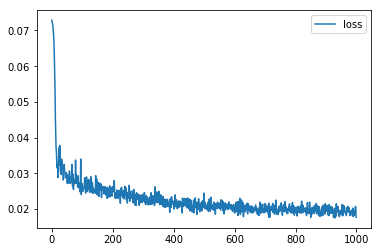

In [74]:

for i in range(1000):
    batch = to_matrix(sample(names,32),max_len=MAX_LENGTH)
    loss_i,_ = s.run([loss,optimize],{input_sequence:batch})
    
    
    history.append(loss_i)
    if (i+1)%100==0:
        clear_output(True)
        print(i+1)
        plt.plot(history,label='loss')
        plt.legend()
        plt.show()

assert np.mean(history[:10]) > np.mean(history[-10:]), "RNN didn't converge."

Rnn sampling

In [174]:
# x_t = tf.placeholder('int32',(1,)) # that seem to work but unoriginal code
x_t = tf.placeholder('int32',(None,))
h_t = tf.Variable(np.zeros([1, rnn_num_units],'float32'))


next_probs,next_h = rnn_one_step(x_t,h_t)

In [169]:
x_t_emb = embed_x(tf.reshape(x_t,[-1,1]))[:,0]

In [170]:
s.run(x_t_emb, {x_t:[20]})

array([[ 0.16572136,  0.06182893, -0.00804286, -0.02712956, -0.07276114,
         0.04574505, -0.08127786,  0.19393715,  0.05559646, -0.01386058,
        -0.00340852, -0.0874066 ,  0.02805582,  0.24174052, -0.0477777 ,
         0.09198685]], dtype=float32)

In [175]:
def generate_sample(seed_phrase=' ',max_length=MAX_LENGTH):
    '''
    The function generates text given a phrase of length at least SEQ_LENGTH.
        
    parameters:
        The phrase is set using the variable seed_phrase
        The optional input "N" is used to set the number of characters of text to predict.     
    '''
    x_sequence = [token_to_id[token] for token in seed_phrase]
    s.run(tf.assign(h_t,h_t.initial_value))
    
    #feed the seed phrase, if any
    for ix in x_sequence[:-1]:
         s.run(tf.assign(h_t,next_h),{x_t:[ix]})
    
    #start generating
    for _ in range(max_length-len(seed_phrase)):
        x_probs,_ = s.run([next_probs,tf.assign(h_t,next_h)],{x_t:[x_sequence[-1]]})
        x_sequence.append(np.random.choice(n_tokens,p=x_probs[0]))
        
    return ''.join([tokens[ix] for ix in x_sequence])

In [45]:
#generate_sample()

In [35]:
seed_phrase = ' '
x_sequence = [token_to_id[token] for token in seed_phrase]
hh = s.run(tf.assign(h_t,h_t.initial_value))

In [164]:
#s.run(tf.assign(h_t,next_h), {x_t:[42], h_t:hh})

In [31]:
x_sequence

[12, 41]

In [30]:
for i in x_sequence[:-1]:
    print([i])

[12]


In [165]:
#s.run(tf.assign(h_t,next_h),{x_t:[None]})

In [176]:
for _ in range(10):
    print(generate_sample())

 BogtyCCCCCCCCCC
 BrinlCCCCCCCCCC
 CychiedCCCCCCCC
 RexaCCCCCCCCCCC
 YlarichaCCCCCCC
 NarontinnCCCCCC
 KureCCCCCCCCCCC
 FesrexCCCCCCCCC
 GligieCCCCCCCCC
 VineaCCCCCCCCCC


In [177]:
for _ in range(50):
    print(generate_sample(' Trump'))

 TrumpCCCCCCCCCC
 TrumpynCCCCCCCC
 TrumpotCCCCCCCC
 TrumpyCCCCCCCCC
 TrumpetfCCCCCCC
 TrumpttaCCCCCCC
 TrumpCCCCCCCCCC
 TrumpCCCCCCCCCC
 TrumpedCCCCCCCC
 TrumpaCCCCCCCCC
 TrumpceCCCCCCCC
 TrumpalaCCCCCCC
 TrumpCCCCCCCCCC
 TrumpCCCCCCCCCC
 TrumpanCCCCCCCC
 TrumpieCCCCCCCC
 TrumpuesCCCCCCC
 TrumpiCCCCCCCCC
 TrumpaikiCCCCCC
 TrumpyCCCCCCCCC
 TrumpetCCCCCCCC
 TrumpaCCCCCCCCC
 TrumpeCCCCCCCCC
 TrumpCCCCCCCCCC
 TrumpeinCCCCCCC
 TrumpiCCCCCCCCC
 TrumpudCCCCCCCC
 TrumpeCCCCCCCCC
 TrumpynCCCCCCCC
 TrumpeenCCCCCCC
 TrumpaCCCCCCCCC
 TrumponCCCCCCCC
 TrumpCCCCCCCCCC
 TrumpanneCCCCCC
 TrumpeCCCCCCCCC
 TrumpyCCCCCCCCC
 TrumpiceCCCCCCC
 TrumpCCCCCCCCCC
 TrumpaCCCCCCCCC
 TrumpeeCCCCCCCC
 TrumpyCCCCCCCCC
 TrumptaCCCCCCCC
 TrumpeCCCCCCCCC
 TrumpyCCCCCCCCC
 TrumpCCCCCCCCCC
 TrumpaCCCCCCCCC
 TrumperyCCCCCCC
 TrumpCCCCCCCCCC
 TrumpuCCCCCCCCC
 TrumpaCCCCCCCCC
